## Stacking
This notebook will show you how to stacks model using aikit

### Regression with OutSamplerTransformer
Let's start by creating a simple Regression dataset

In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=30, n_informative=10, n_targets=1, random_state=123)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123)

Matplotlib won't work


C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


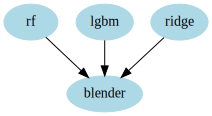

In [2]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

from aikit.pipeline import GraphPipeline
from aikit.models import OutSamplerTransformer

cv = 10

stacking_model = GraphPipeline(models = {
    "rf"   : OutSamplerTransformer(RandomForestRegressor(random_state=123, n_estimators=10) , cv = cv),
    "lgbm" : OutSamplerTransformer(LGBMRegressor(random_state=123, n_estimators=10)         ,  cv = cv),
    "ridge": OutSamplerTransformer(Ridge(random_state=123)     , cv = cv),
    "blender":Ridge()
    }, edges = [("rf","blender"),("lgbm","blender"),("ridge","blender")])


stacking_model.graphviz

This model behaves like a regular sklearn regressor.

**It can be fitted :**

In [3]:
stacking_model.fit(Xtrain, ytrain)

GraphPipeline(edges=[('rf', 'blender'), ('lgbm', 'blender'),
                     ('ridge', 'blender')],
              models={'blender': Ridge(alpha=1.0, copy_X=True,
                                       fit_intercept=True, max_iter=None,
                                       normalize=False, random_state=None,
                                       solver='auto', tol=0.001),
                      'lgbm': OutSamplerTransformer(columns_prefix=None, cv=10,
                                                    desired_output_type=None,
                                                    model=LGBMRegressor(boosting_type='gbdt',
                                                                        class_weight=...
                                                                              n_jobs=None,
                                                                              oob_score=False,
                                                                              random_state

**You can predict**

In [4]:
yhat_test = stacking_model.predict(Xtest)

In [5]:
from sklearn.metrics import mean_squared_error
10_000 * mean_squared_error(ytest, yhat_test)

9.978737586369565

Let's describe what goes on during the fit:

1. cross_val_predict is called on each of the model => This create *out-of-sample* predictions for each observation
2. the each model is re-fitted on the full data => To be ready when called for a new prediction
3. The blender is given the out-of-sample prediction of the 3 models to fit a final model

The 'OutSamplerTransformer' object implements the logic to create out-of-sample prediction whereas GraphPipeline act to pass transformation from one node to the next(s).

#### With that logic you can do more complexe things
Let's say you have missing value to fill before feeding the data to the models  (Remark : this is not the case here).

You can just add a node at the top of the pipeline:

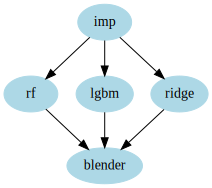

In [6]:
from aikit.transformers import NumImputer

stacking_model = GraphPipeline(models = {
    "imp"  : NumImputer(),
    "rf"   : OutSamplerTransformer(RandomForestRegressor(random_state=123, n_estimators=10) , cv = cv),
    "lgbm" : OutSamplerTransformer(LGBMRegressor(random_state=123, n_estimators=10)         ,  cv = cv),
    "ridge": OutSamplerTransformer(Ridge(random_state=123)     , cv = cv),
    "blender":Ridge()
    }, edges = [("imp", "rf","blender"),("imp", "lgbm","blender"),("imp", "ridge","blender")])

stacking_model.graphviz


Let's say you want to pass to the blender the predictions of the model **along with** the original features.

You can just add another edge :

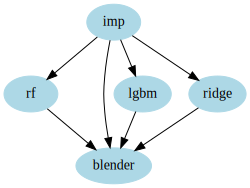

In [7]:
from aikit.transformers import NumImputer

stacking_model = GraphPipeline(models = {
    "imp"  : NumImputer(),
    "rf"   : OutSamplerTransformer(RandomForestRegressor(random_state=123, n_estimators=10) , cv = cv),
    "lgbm" : OutSamplerTransformer(LGBMRegressor(random_state=123, n_estimators=10)         ,  cv = cv),
    "ridge": OutSamplerTransformer(Ridge(random_state=123)     , cv = cv),
    "blender":Ridge()
    }, edges = [("imp", "rf","blender"),("imp", "lgbm","blender"),("imp", "ridge","blender"), ("imp", "blender")])

stacking_model.graphviz


### Example on a Classification task

In [8]:
from aikit.datasets.datasets import load_dataset, DatasetEnum
Xtrain, y_train, _ ,_ , _ = load_dataset(DatasetEnum.titanic)
Xtrain.head(10)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,NaN,175.0,"Dorchester, MA"
1,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,NaN,NaN,"Winnipeg, MB"
2,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,9,NaN,NaN
3,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,NaN,NaN,NaN
4,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,8,NaN,NaN
5,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,NaN,S,NaN,NaN,"Antwerp, Belgium / Stanton, OH"
6,3,"Reed, Mr. James George",male,NaN,0,0,362316,7.2500,NaN,S,NaN,NaN,NaN
7,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,8,NaN,"Brooklyn, NY"
8,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18.0,1,0,13695,60.0000,C31,S,6,NaN,"Huntington, WV"
9,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.5500,NaN,S,NaN,109.0,London


#### You can also stack models that works on different part of the data, for example :
* a CountVectorizer + Logit model that works on "text-like" columns 
* along with a NumericalEncoder + Random Forest RandomForestClassifier for the other columns

C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


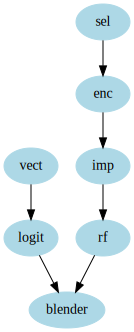

In [9]:
from aikit.transformers import CountVectorizerWrapper, NumericalEncoder, NumImputer, ColumnsSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from aikit.models import OutSamplerTransformer
from aikit.pipeline import GraphPipeline

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(10, random_state=123, shuffle=True)


text_cols     = ["name","ticket"]
non_text_cols = [c for c in Xtrain.columns if c not in text_cols]

gpipeline = GraphPipeline(models = {
    "sel":ColumnsSelector(columns_to_use=non_text_cols),
    "enc":NumericalEncoder(columns_to_use="object"),
    "imp":NumImputer(),
    "vect":CountVectorizerWrapper(analyzer="word",columns_to_use=text_cols),
    "rf":OutSamplerTransformer(RandomForestClassifier(n_estimators=100, random_state=123),cv=cv),
    "logit":OutSamplerTransformer(LogisticRegression(random_state=123),cv=cv),
    "blender":LogisticRegression(random_state=123)
},
              edges = [("sel","enc","imp","rf", "blender"),("vect","logit","blender")])

gpipeline.fit(Xtrain,y_train)
gpipeline.graphviz


### Probabilities calibration (Platt's scaling)
Using that object you can also re-calibrate your probabilities.
This can be done by using a method called 'Platt's scaling' https://en.wikipedia.org/wiki/Platt_scaling/)

Which consist in feeding the probability of one model to a Logistic Regression which will re-scale them.


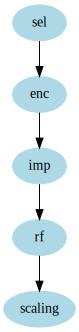

In [10]:
rf_rescaled = GraphPipeline(models = {
    "sel"  : ColumnsSelector(columns_to_use=non_text_cols),
    "enc"  : NumericalEncoder(),
    "imp"  : NumImputer(),
    "rf"   : OutSamplerTransformer( RandomForestClassifier(class_weight = "auto"), cv = cv),
    "scaling":LogisticRegression()
    }, edges = [('sel','enc','imp','rf','scaling')]
)
rf_rescaled.graphviz